# Instalasi & Import

In [34]:
# Cell 1: Install & Import
# Instalasi library yang diperlukan
!pip install xgboost optuna shap

import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import shap
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel

from optuna.samplers import TPESampler, NSGAIISampler, RandomSampler
from optuna.pruners import SuccessiveHalvingPruner, MedianPruner
from xgboost.callback import TrainingCallback

# Konfigurasi Lingkungan
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
pio.renderers.default = "iframe" # Agar grafik interaktif muncul di Kaggle

print("✅ Setup Selesai.")
print(f"🔹 XGBoost Version: {xgb.__version__} (Target: v2.0+)")
print(f"🔹 Optuna Version: {optuna.__version__}")
print(f"🔹 GPU Status: {'Aktif (CUDA)' if xgb.build_info()['USE_CUDA'] else 'Tidak Terdeteksi!'}")

✅ Setup Selesai.
🔹 XGBoost Version: 3.1.0 (Target: v2.0+)
🔹 Optuna Version: 2.10.1
🔹 GPU Status: Aktif (CUDA)


# Load Dataset (Otomatis)

In [35]:
# Cell 2: Load Data
print("📂 Mencari file dataset di /kaggle/input/ ...")

train_path = None
test_path = None

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        if "training" in filename.lower() and "csv" in filename:
            train_path = full_path
        elif "testing" in filename.lower() and "csv" in filename:
            test_path = full_path

if train_path and test_path:
    print(f"✅ Training Data: {train_path}")
    print(f"✅ Testing Data: {test_path}")
    
    # Load Data Asli
    df_train_full = pd.read_csv(train_path)
    df_test_raw = pd.read_csv(test_path)
    
    print(f"🔹 Shape Train Awal: {df_train_full.shape}")
    print(f"🔹 Shape Test Awal:  {df_test_raw.shape}")
else:
    raise FileNotFoundError("❌ File dataset UNSW-NB15 tidak ditemukan! Pastikan sudah Add Input.")

📂 Mencari file dataset di /kaggle/input/ ...
✅ Training Data: /kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
✅ Testing Data: /kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
🔹 Shape Train Awal: (175341, 45)
🔹 Shape Test Awal:  (82332, 45)


# Preprocessing & Class Weights

In [36]:
# Cell 3: Preprocessing (SOFT FEATURE SELECTION)

# 1. Bersihkan Kolom Sampah
drop_cols = ['id'] 
df_train_full = df_train_full.drop(columns=drop_cols, errors='ignore')
df_test_raw = df_test_raw.drop(columns=drop_cols, errors='ignore')

# 2. Pisahkan Fitur & Target
X_raw = df_train_full.drop(columns=['attack_cat', 'label'])
y_raw = df_train_full['attack_cat']

X_test_final_raw = df_test_raw.drop(columns=['attack_cat', 'label'])
y_test_final_raw = df_test_raw['attack_cat']

# 3. Encoding Kategorikal
cat_cols = X_raw.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    full_col = pd.concat([X_raw[col], X_test_final_raw[col]], axis=0).astype(str)
    le.fit(full_col)
    X_raw[col] = le.transform(X_raw[col].astype(str))
    X_test_final_raw[col] = le.transform(X_test_final_raw[col].astype(str))

# 4. Encoding Target
le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)
y_test_final = le_target.transform(y_test_final_raw)

# 5. Scaling
scaler = StandardScaler()
X_enc = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)
X_test_enc = pd.DataFrame(scaler.transform(X_test_final_raw), columns=X_test_final_raw.columns)

# 6. Optimasi Memori (Float32) - Wajib untuk P100
float_cols = X_enc.select_dtypes(include=['float64']).columns
X_enc[float_cols] = X_enc[float_cols].astype('float32')
X_test_enc[float_cols] = X_test_enc[float_cols].astype('float32')

# --- MODIFIKASI: SOFT FEATURE SELECTION ---
print("\n🔍 Menjalankan Soft Feature Selection...")

# Latih model ringan sebentar untuk cek importance
selection_model = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=len(le_target.classes_),
    tree_method='hist', device='cuda',
    random_state=42, verbosity=0
)
selection_model.fit(X_enc, y)

# KUNCI PERUBAHAN ADA DI SINI:
# threshold='0.25*mean' -> Syarat lulus lebih gampang. 
# Fitur lemah tetap disimpan, cuma fitur sampah yang dibuang.
selector = SelectFromModel(selection_model, threshold='0.25*mean', prefit=True)

selected_feat_names = X_enc.columns[selector.get_support()]
X_selected = pd.DataFrame(selector.transform(X_enc), columns=selected_feat_names)
X_test_selected = pd.DataFrame(selector.transform(X_test_enc), columns=selected_feat_names)

print(f"✅ Seleksi Selesai.")
print(f"🔹 Fitur Awal: {X_enc.shape[1]}")
print(f"🔹 Fitur Tersisa: {X_selected.shape[1]} (Target ideal: 25-35 fitur)")

# 7. Splitting (Train/Val)
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Soft Class Weighting (Tetap pakai SQRT seperti request sebelumnya agar F1 terjaga)
raw_weights = compute_sample_weight(class_weight='balanced', y=y_train)
sample_weights_train = np.sqrt(raw_weights)

print(f"🔹 Train Set: {X_train.shape}")


🔍 Menjalankan Soft Feature Selection...
✅ Seleksi Selesai.
🔹 Fitur Awal: 42
🔹 Fitur Tersisa: 16 (Target ideal: 25-35 fitur)
🔹 Train Set: (140272, 16)


# Definisi Objective Function (Generic)

In [37]:
# Cell 4: Objective Function (Tuning Space Dilonggarkan)

class OptunaPruningCallback(TrainingCallback):
    def __init__(self, trial, metric_name):
        self.trial = trial
        self.metric_name = metric_name
        
    def after_iteration(self, model, epoch, evals_log):
        if not evals_log: return False
        score = evals_log['validation_0'][self.metric_name][-1]
        self.trial.report(score, epoch)
        if self.trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        return False

def objective_xgboost(trial):
    # --- PERUBAHAN 3: HYPERPARAMETER SPACE DISESUAIKAN ---
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 4000), # Tambah pohon
        'max_depth': trial.suggest_int('max_depth', 6, 15), # Izinkan pohon lebih dalam
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # Kurangi batas regularisasi agar model mau belajar kelas sulit
        'gamma': trial.suggest_float('gamma', 0, 2), # Dulu 0-5, sekarang diperkecil
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5), # Perkecil agar sensitif
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 0.1, log=True),
        
        # Fixed
        'objective': 'multi:softmax',
        'num_class': len(le_target.classes_),
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'mlogloss',
        'verbosity': 0
    }

    pruning_callback = OptunaPruningCallback(trial, "mlogloss")

    model = xgb.XGBClassifier(**param, random_state=42, callbacks=[pruning_callback])
    
    model.fit(
        X_train, y_train,
        sample_weight=sample_weights_train, # Pakai Soft Weights
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')
    
    return f1

# Strategi 1 - Optuna TPE (Tree-structured Parzen Estimator)

In [38]:
# Cell 5: Optimasi TPE (Bayesian)
print("🚀 Memulai Optimasi TPE (Tree-structured Parzen Estimator)...")
start_time = time.time()

study_tpe = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)

study_tpe.optimize(objective_xgboost, n_trials=10) # 30 Trial
time_tpe = time.time() - start_time

print(f"✅ TPE Selesai dalam: {time_tpe:.2f} detik.")
print(f"🏆 Best F1 TPE: {study_tpe.best_value:.4f}")

[I 2025-12-30 16:35:13,959] A new study created in memory with name: no-name-6e4b6bb2-152d-43fb-b454-ba684d7b979c


🚀 Memulai Optimasi TPE (Tree-structured Parzen Estimator)...


[I 2025-12-30 16:35:52,397] Trial 0 finished with value: 0.6576923449408593 and parameters: {'n_estimators': 2123, 'max_depth': 15, 'learning_rate': 0.08960785365368121, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.3119890406724053, 'min_child_weight': 1, 'reg_alpha': 0.011567327199145964, 'reg_lambda': 0.00016136341713591298}. Best is trial 0 with value: 0.6576923449408593.
[I 2025-12-30 16:36:19,434] Trial 1 finished with value: 0.6563964993575763 and parameters: {'n_estimators': 3124, 'max_depth': 6, 'learning_rate': 0.18276027831785724, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.36364993441420124, 'min_child_weight': 1, 'reg_alpha': 1.348018029089077e-06, 'reg_lambda': 4.712973756110775e-05}. Best is trial 0 with value: 0.6576923449408593.
[I 2025-12-30 16:36:53,060] Trial 2 finished with value: 0.6577272326934123 and parameters: {'n_estimators': 2296, 'max_depth': 8, 'learning_rate': 0.0625228791640621

✅ TPE Selesai dalam: 413.89 detik.
🏆 Best F1 TPE: 0.6639


# Strategi 2 - Optuna ASHA (Asynchronous Successive Halving)

In [39]:
# Cell 6: Optimasi ASHA (Pruning Agresif)
print("🚀 Memulai Optimasi ASHA (Asynchronous Successive Halving)...")
start_time = time.time()

# ASHA di Optuna diatur lewat Pruner
study_asha = optuna.create_study(
    direction='maximize',
    sampler=RandomSampler(seed=42), # Sampler random agar eksplorasi luas
    pruner=SuccessiveHalvingPruner(min_resource=100, reduction_factor=3)
)

study_asha.optimize(objective_xgboost, n_trials=10)
time_asha = time.time() - start_time

print(f"✅ ASHA Selesai dalam: {time_asha:.2f} detik.")
print(f"🏆 Best F1 ASHA: {study_asha.best_value:.4f}")

[I 2025-12-30 16:42:07,862] A new study created in memory with name: no-name-f6748cda-61a7-4008-b863-23ca77c9ea97


🚀 Memulai Optimasi ASHA (Asynchronous Successive Halving)...


[I 2025-12-30 16:42:46,346] Trial 0 finished with value: 0.6576923449408593 and parameters: {'n_estimators': 2123, 'max_depth': 15, 'learning_rate': 0.08960785365368121, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.3119890406724053, 'min_child_weight': 1, 'reg_alpha': 0.011567327199145964, 'reg_lambda': 0.00016136341713591298}. Best is trial 0 with value: 0.6576923449408593.
[I 2025-12-30 16:42:50,431] Trial 1 pruned. 
[I 2025-12-30 16:43:05,510] Trial 2 pruned. 
[I 2025-12-30 16:43:37,794] Trial 3 pruned. 
[I 2025-12-30 16:43:39,677] Trial 4 pruned. 
[I 2025-12-30 16:43:44,837] Trial 5 pruned. 
[I 2025-12-30 16:44:17,173] Trial 6 pruned. 
[I 2025-12-30 16:44:19,901] Trial 7 pruned. 
[I 2025-12-30 16:44:25,549] Trial 8 pruned. 
[I 2025-12-30 16:45:04,240] Trial 9 finished with value: 0.6562817193626059 and parameters: {'n_estimators': 2870, 'max_depth': 9, 'learning_rate': 0.012097379927033842, 'subsample': 0.7243929286862649, 'colsample_bytree': 

✅ ASHA Selesai dalam: 176.38 detik.
🏆 Best F1 ASHA: 0.6577


# Strategi 3 - Optuna NSGA-II (Genetic Algorithm)

In [40]:
# Cell 7: Optimasi NSGA-II (Evolutionary Algorithm)
print("🚀 Memulai Optimasi NSGA-II (Genetic Algorithm)...")
start_time = time.time()

study_nsga = optuna.create_study(
    direction='maximize',
    sampler=NSGAIISampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)

study_nsga.optimize(objective_xgboost, n_trials=10)
time_nsga = time.time() - start_time

print(f"✅ NSGA-II Selesai dalam: {time_nsga:.2f} detik.")
print(f"🏆 Best F1 NSGA-II: {study_nsga.best_value:.4f}")

[I 2025-12-30 16:45:04,249] A new study created in memory with name: no-name-cb608a34-a45a-4065-985e-4d00cacf1997


🚀 Memulai Optimasi NSGA-II (Genetic Algorithm)...


[I 2025-12-30 16:45:42,744] Trial 0 finished with value: 0.6576923449408593 and parameters: {'n_estimators': 2123, 'max_depth': 15, 'learning_rate': 0.08960785365368121, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.3119890406724053, 'min_child_weight': 1, 'reg_alpha': 0.011567327199145964, 'reg_lambda': 0.00016136341713591298}. Best is trial 0 with value: 0.6576923449408593.
[I 2025-12-30 16:46:09,914] Trial 1 finished with value: 0.6563964993575763 and parameters: {'n_estimators': 3124, 'max_depth': 6, 'learning_rate': 0.18276027831785724, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.36364993441420124, 'min_child_weight': 1, 'reg_alpha': 1.348018029089077e-06, 'reg_lambda': 4.712973756110775e-05}. Best is trial 0 with value: 0.6576923449408593.
[I 2025-12-30 16:46:43,575] Trial 2 finished with value: 0.6577272326934123 and parameters: {'n_estimators': 2296, 'max_depth': 8, 'learning_rate': 0.0625228791640621

✅ NSGA-II Selesai dalam: 416.17 detik.
🏆 Best F1 NSGA-II: 0.6639


# Evaluasi Model Final & Komparasi

In [41]:
# Cell 8: Training Final & Evaluasi (Update Soft Weights)

def train_evaluate_final(study, method_name):
    print(f"⚙️ Melatih Model Final ({method_name})...")
    
    best_params = study.best_params
    best_params.update({
        'objective': 'multi:softmax',
        'num_class': len(le_target.classes_),
        'tree_method': 'hist',
        'device': 'cuda',
        'verbosity': 0
    })
    
    # HITUNG BOBOT FINAL (FULL DATA) DENGAN SQRT JUGA
    raw_full_weights = compute_sample_weight(class_weight='balanced', y=y)
    soft_full_weights = np.sqrt(raw_full_weights) # <--- PENTING: Pakai SQRT di sini juga
    
    # Train di FULL DATA
    model = xgb.XGBClassifier(**best_params, random_state=42)
    model.fit(X_selected, y, sample_weight=soft_full_weights)
    
    preds = model.predict(X_test_selected)
    
    return model, preds

# Eksekusi ulang
model_tpe, preds_tpe = train_evaluate_final(study_tpe, "TPE")
model_asha, preds_asha = train_evaluate_final(study_asha, "ASHA")
model_nsga, preds_nsga = train_evaluate_final(study_nsga, "NSGA-II")

# Rekap Hasil
def get_metrics(y_true, y_pred, time_taken, study):
    return {
        'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro'),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Macro)': precision_score(y_true, y_pred, average='macro'),
        'Recall (Macro)': recall_score(y_true, y_pred, average='macro'),
        'Waktu Optimasi (s)': time_taken,
        'Best Trial Ke-': study.best_trial.number
    }

results = pd.DataFrame([
    get_metrics(y_test_final, preds_tpe, time_tpe, study_tpe),
    get_metrics(y_test_final, preds_asha, time_asha, study_asha),
    get_metrics(y_test_final, preds_nsga, time_nsga, study_nsga)
], index=['TPE', 'ASHA', 'NSGA-II'])

print("\n=== HASIL AKHIR KOMPARASI (DATA TESTING) ===")
display(results)

# Detail Report TPE (Contoh)
print("\n--- Detailed Classification Report (Metode TPE) ---")
print(classification_report(y_test_final, preds_tpe, target_names=le_target.classes_))

print("\n--- Detailed Classification Report (Metode ASHA) ---")
print(classification_report(y_test_final, preds_asha, target_names=le_target.classes_))

print("\n--- Detailed Classification Report (Metode NSGA-II) ---")
print(classification_report(y_test_final, preds_nsga, target_names=le_target.classes_))

⚙️ Melatih Model Final (TPE)...
⚙️ Melatih Model Final (ASHA)...
⚙️ Melatih Model Final (NSGA-II)...

=== HASIL AKHIR KOMPARASI (DATA TESTING) ===


,F1-Score (Macro),Accuracy,Precision (Macro),Recall (Macro),Waktu Optimasi (s),Best Trial Ke-
TPE,0.546173,0.732923,0.531367,0.62522,413.894482,6
ASHA,0.532651,0.740089,0.528480,0.58072,176.379058,0
NSGA-II,0.546173,0.732923,0.531367,0.62522,416.165673,6



--- Detailed Classification Report (Metode TPE) ---
                precision    recall  f1-score   support

      Analysis       0.07      0.23      0.10       677
      Backdoor       0.03      0.10      0.04       583
           DoS       0.38      0.48      0.43      4089
      Exploits       0.75      0.68      0.71     11132
       Fuzzers       0.27      0.62      0.38      6062
       Generic       1.00      0.98      0.99     18871
        Normal       0.97      0.68      0.80     37000
Reconnaissance       0.90      0.83      0.86      3496
     Shellcode       0.31      0.91      0.46       378
         Worms       0.65      0.75      0.69        44

      accuracy                           0.73     82332
     macro avg       0.53      0.63      0.55     82332
  weighted avg       0.85      0.73      0.77     82332


--- Detailed Classification Report (Metode ASHA) ---
                precision    recall  f1-score   support

      Analysis       0.06      0.13      0.08    

# Visualisasi Analisis Data & Penanganan Imbalance

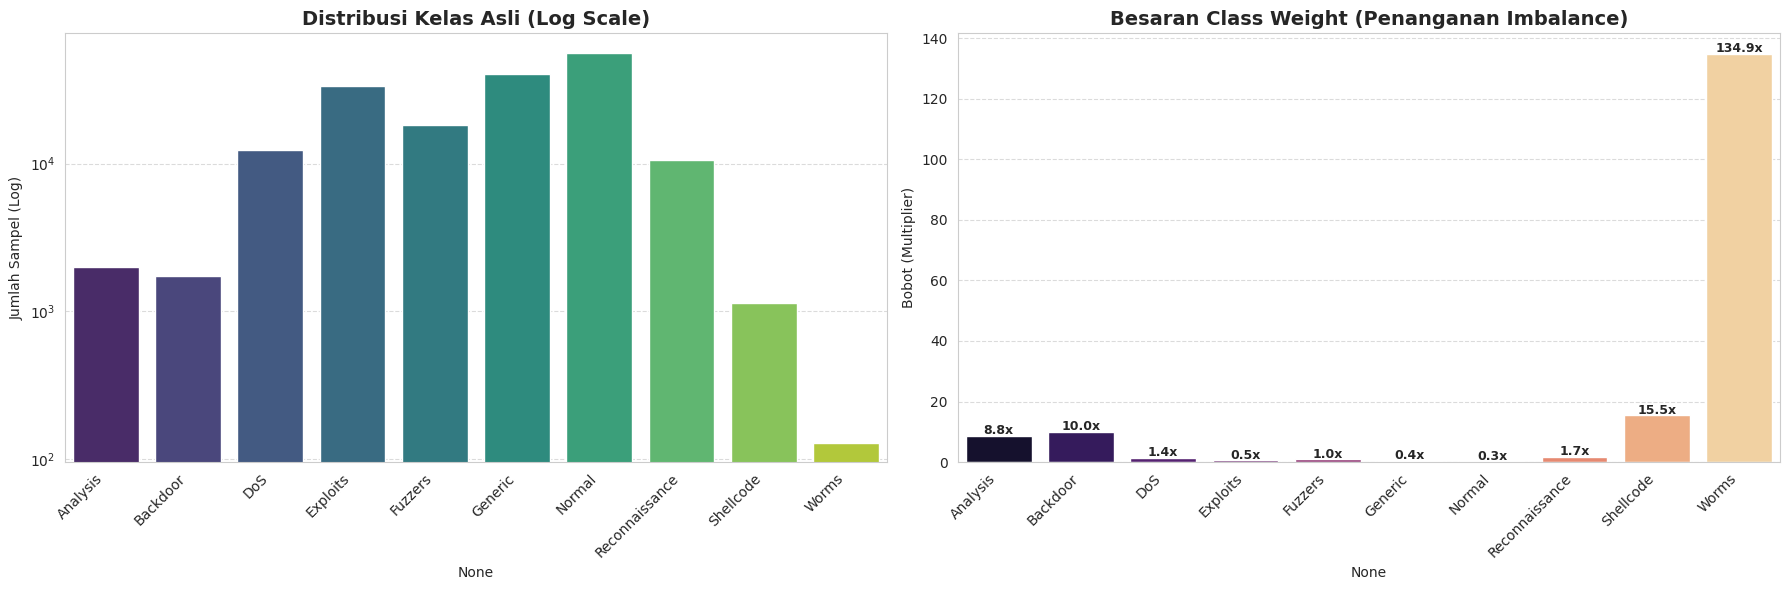

In [42]:
# Cell Tambahan 1: Visualisasi Distribusi Data vs Bobot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Siapkan Data
class_counts = pd.Series(y).value_counts().sort_index()
class_names = le_target.classes_

# Ambil bobot unik per kelas (karena sample_weight dihitung per baris, kita ambil 1 perwakilan per kelas)
unique_weights = {}
for cls_idx, cls_name in enumerate(class_names):
    # Cari indeks pertama dimana kelas ini muncul
    idx = np.where(y == cls_idx)[0][0]
    unique_weights[cls_name] = compute_sample_weight('balanced', y)[idx]

weights_series = pd.Series(unique_weights).sort_index()

# 2. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot A: Distribusi Jumlah Data Asli (Log Scale agar kelas minoritas terlihat)
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Distribusi Kelas Asli (Log Scale)", fontsize=14, fontweight='bold')
axes[0].set_yscale("log") # PENTING: Pakai Log Scale
axes[0].set_ylabel("Jumlah Sampel (Log)")
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot B: Bobot yang Diberikan (Class Weights)
sns.barplot(x=weights_series.index, y=weights_series.values, ax=axes[1], palette="magma")
axes[1].set_title("Besaran Class Weight (Penanganan Imbalance)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Bobot (Multiplier)")
axes[1].set_xticklabels(weights_series.index, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Anotasi
for i, v in enumerate(weights_series.values):
    axes[1].text(i, v + 0.5, f"{v:.1f}x", ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Visualisasi 2 Hasil Seleksi Fitur

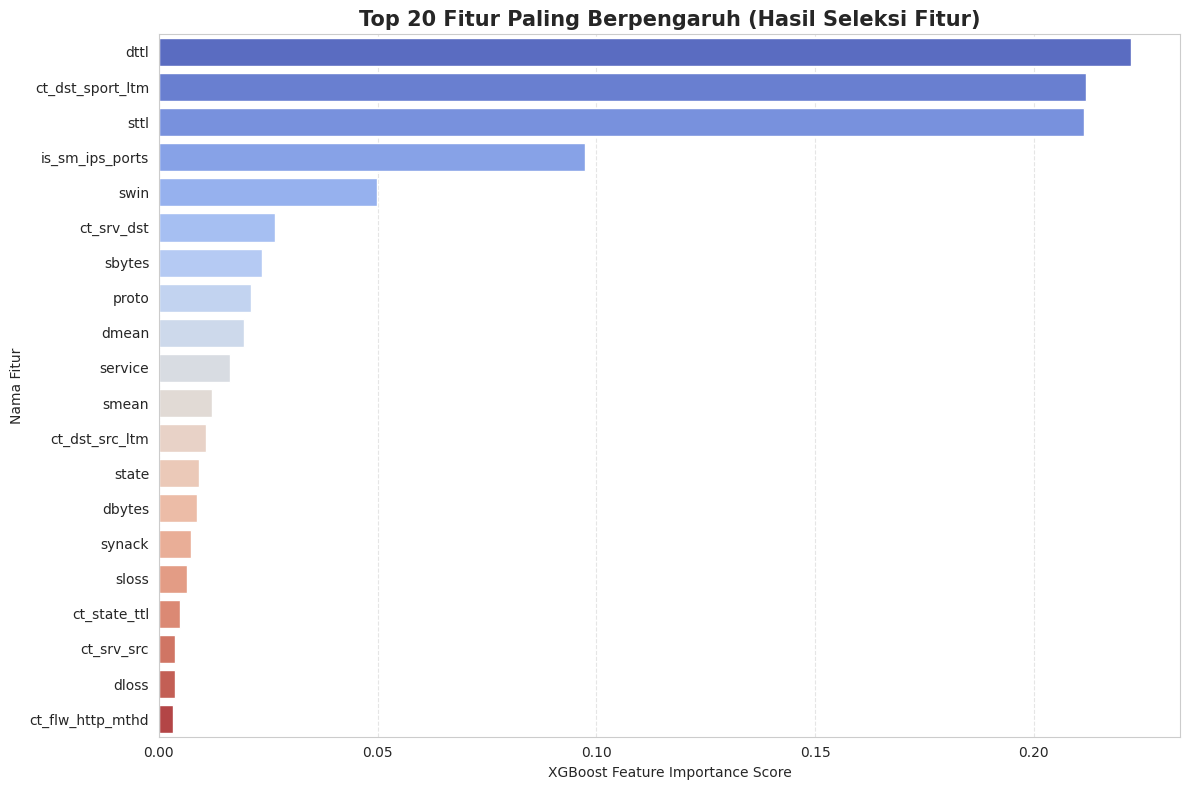

In [43]:
# Cell Tambahan 2: Visualisasi Feature Importance
# Kita ambil feature importance dari model 'selection_model' yang dipakai di Cell 3

# 1. Ambil Importance
importances = selection_model.feature_importances_
feature_names = X_enc.columns

# Buat DataFrame
df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(20) # Top 20 saja

# 2. Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_imp, palette='coolwarm')
plt.title("Top 20 Fitur Paling Berpengaruh (Hasil Seleksi Fitur)", fontsize=15, fontweight='bold')
plt.xlabel("XGBoost Feature Importance Score")
plt.ylabel("Nama Fitur")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Visualisasi 3 Perbandingan Kecepatan Optimasi (TPE vs ASHA vs NSGA-II)

In [44]:
# Cell Tambahan 3: Grafik Konvergensi Komparatif
import plotly.graph_objects as go

# Fungsi helper untuk ekstrak history
def get_optimization_history(study):
    df = study.trials_dataframe()
    # Hanya ambil trial yang COMPLETE (bukan pruned)
    df_success = df[df.state == 'COMPLETE'].sort_values(by='number')
    # Hitung best value kumulatif (running maximum)
    df_success['best_value'] = df_success['value'].cummax()
    return df_success

df_tpe = get_optimization_history(study_tpe)
df_asha = get_optimization_history(study_asha)
df_nsga = get_optimization_history(study_nsga)

# Plotting Interactive Line Chart
fig = go.Figure()

# Garis TPE
fig.add_trace(go.Scatter(
    x=df_tpe['number'], y=df_tpe['best_value'],
    mode='lines+markers', name='TPE (Bayesian)',
    line=dict(color='blue', width=2)
))

# Garis ASHA
fig.add_trace(go.Scatter(
    x=df_asha['number'], y=df_asha['best_value'],
    mode='lines+markers', name='ASHA (Pruning)',
    line=dict(color='green', width=2, dash='dot') # Putus-putus biar beda
))

# Garis NSGA-II
fig.add_trace(go.Scatter(
    x=df_nsga['number'], y=df_nsga['best_value'],
    mode='lines+markers', name='NSGA-II (Evolutionary)',
    line=dict(color='red', width=2)
))

fig.update_layout(
    title='<b>Dinamika Optimasi Hiperparameter</b>: Seberapa Cepat Menemukan F1 Terbaik?',
    xaxis_title='Jumlah Trial (Iterasi)',
    yaxis_title='Best F1-Score (Validation)',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99)
)
fig.show()

# Visualisasi 4 Evaluasi Performa Akhir (Confusion Matrix)

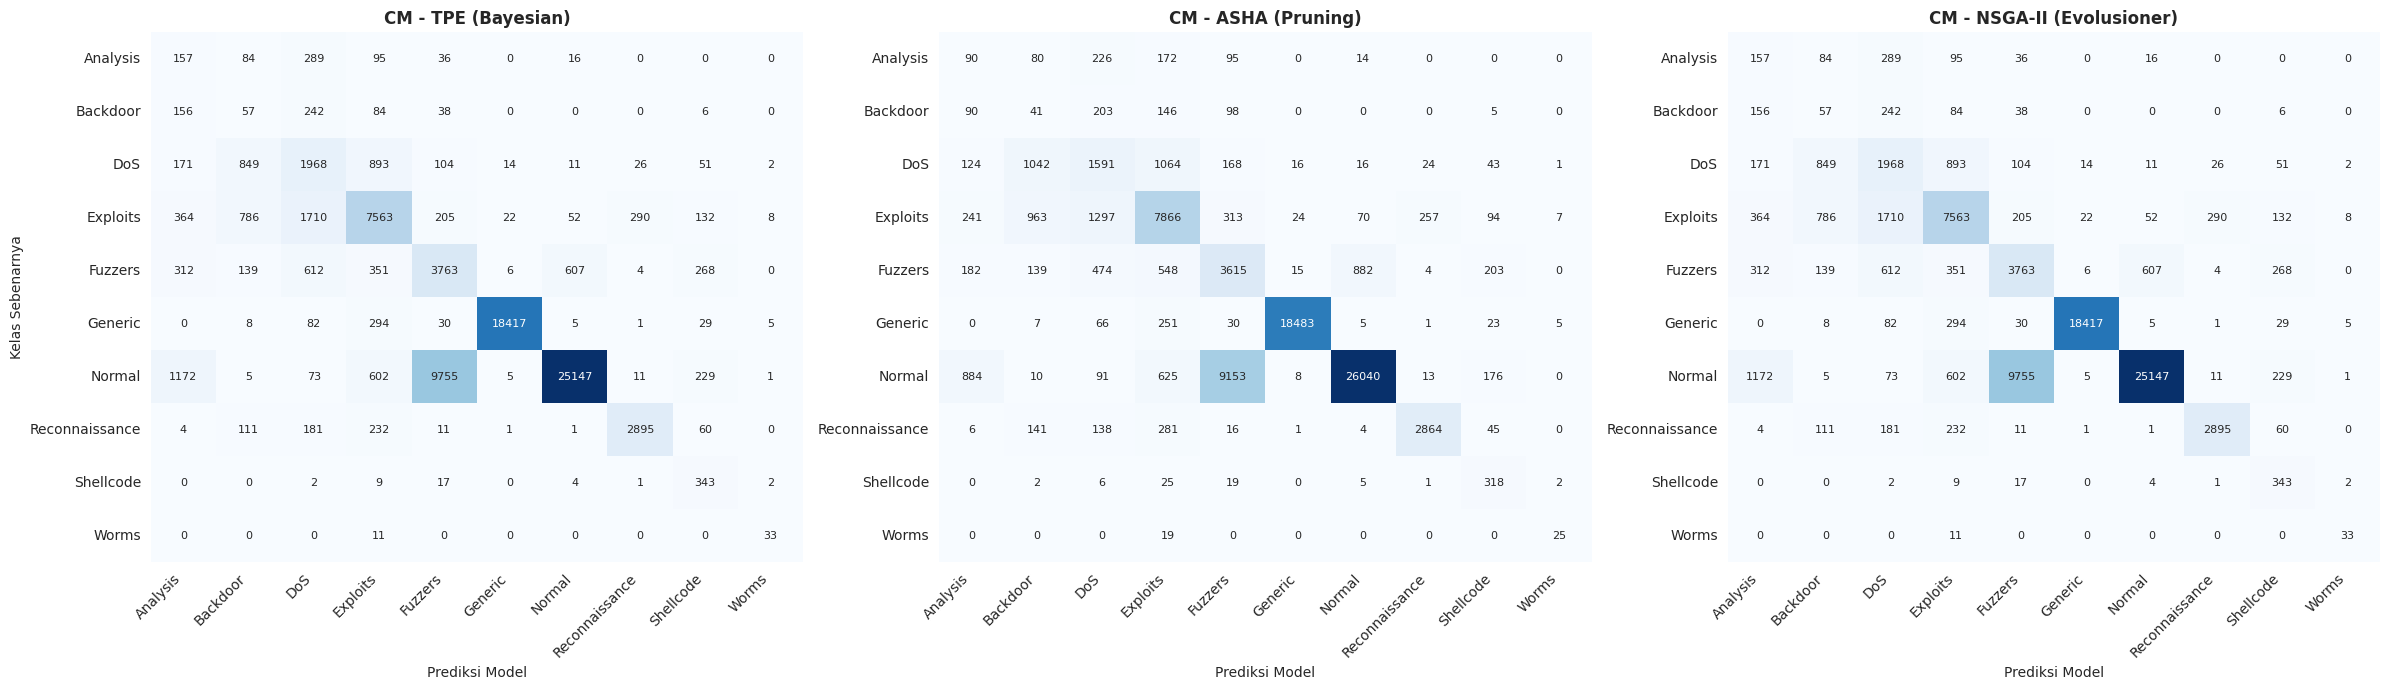


=== Riwayat Optimasi TPE ===



=== Riwayat Optimasi ASHA ===



=== Riwayat Optimasi NSGA-II ===


In [45]:
# Cell Tambahan 4: Confusion Matrix Komparatif
def plot_cm_custom(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    # Normalisasi agar warnanya berdasarkan persentase kebenaran per kelas
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=le_target.classes_, yticklabels=le_target.classes_,
                annot_kws={"size": 8}) # Font kecil biar muat
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel('Prediksi Model')
    ax.set_xticklabels(le_target.classes_, rotation=45, ha='right')

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

plot_cm_custom(y_test_final, preds_tpe, "CM - TPE (Bayesian)", axes[0])
plot_cm_custom(y_test_final, preds_asha, "CM - ASHA (Pruning)", axes[1])
plot_cm_custom(y_test_final, preds_nsga, "CM - NSGA-II (Evolusioner)", axes[2])

axes[0].set_ylabel('Kelas Sebenarnya')
plt.tight_layout()
plt.show()

# 2. Grafik Konvergensi (Plotly)
print("\n=== Riwayat Optimasi TPE ===")
plot_optimization_history(study_tpe).show()

print("\n=== Riwayat Optimasi ASHA ===")
plot_optimization_history(study_asha).show()

print("\n=== Riwayat Optimasi NSGA-II ===")
plot_optimization_history(study_nsga).show()

# Visualisasi 5 Explainable AI (SHAP) - Wrapper Method

⏳ Menghitung SHAP Values (Estimasi waktu: 1-2 menit)...


  0%|          | 0/100 [00:00<?, ?it/s]

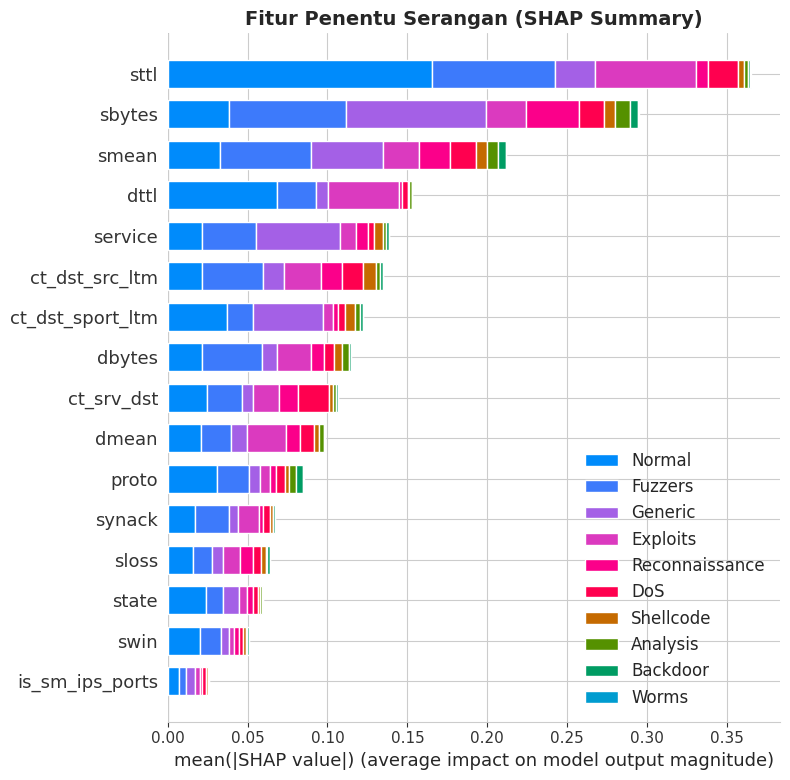

In [46]:
# Cell Tambahan 5: SHAP Values (Anti-Error Version)
print("⏳ Menghitung SHAP Values (Estimasi waktu: 1-2 menit)...")

# 1. Ambil Sampel Kecil (100 Data)
# SHAP KernelExplainer lambat, jadi pakai 100 data sudah cukup untuk representasi
X_shap_sample = X_test_selected.sample(100, random_state=42)

# 2. Wrapper Function (PENTING: Bypass error kompatibilitas)
def predict_wrapper(data_numpy):
    # Kembalikan ke format DataFrame dengan nama kolom yang benar & tipe float32
    data_df = pd.DataFrame(data_numpy, columns=X_shap_sample.columns)
    data_df = data_df.astype('float32') 
    return model_tpe.predict_proba(data_df)

# 3. Inisialisasi Explainer
# Gunakan K-Means untuk meringkas background data (mempercepat hitungan)
background_data = shap.kmeans(X_shap_sample, 10) 
explainer = shap.KernelExplainer(predict_wrapper, background_data)

# 4. Hitung SHAP Values
shap_values = explainer.shap_values(X_shap_sample, nsamples=100)

# 5. Plotting
plt.figure(figsize=(10, 6))
plt.title("Fitur Penentu Serangan (SHAP Summary)", fontsize=14, fontweight='bold')
shap.summary_plot(
    shap_values, 
    X_shap_sample, 
    class_names=le_target.classes_,
    plot_type="bar" # Bar chart paling mudah dibaca untuk multiclass
)
plt.show()

# Analisis Kepentingan Hyperparameter

In [50]:
# Cell Tambahan: Analisis Kepentingan Hiperparameter (FIXED - MDI Method)
from optuna.visualization import plot_param_importances
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator

print("📊 Menganalisis Pengaruh Hiperparameter terhadap F1-Score...")
print("⚠️ Menggunakan metode MDI (Mean Decrease Impurity) untuk stabilitas.\n")

# Kita buat evaluator khusus (MDI) yang lebih robust daripada fANOVA
mdi_evaluator = MeanDecreaseImpurityImportanceEvaluator()

# 1. Visualisasi untuk TPE
print("=== 1. Hyperparameter Importance (TPE) ===")
try:
    fig_tpe_imp = plot_param_importances(study_tpe, evaluator=mdi_evaluator)
    fig_tpe_imp.update_layout(
        title="Hyperparameter Importance - Metode TPE",
        template="plotly_white",
        height=500
    )
    fig_tpe_imp.show()
except Exception as e:
    print(f"⚠️ Gagal memplot TPE: {e}")

# 2. Visualisasi untuk ASHA
print("=== 2. Hyperparameter Importance (ASHA) ===")
try:
    fig_asha_imp = plot_param_importances(study_asha, evaluator=mdi_evaluator)
    fig_asha_imp.update_layout(
        title="Hyperparameter Importance - Metode ASHA",
        template="plotly_white",
        height=500
    )
    fig_asha_imp.show()
except Exception as e:
    print(f"⚠️ Data trial ASHA mungkin belum cukup/terlalu banyak pruned: {e}")

# 3. Visualisasi untuk NSGA-II
print("=== 3. Hyperparameter Importance (NSGA-II) ===")
try:
    fig_nsga_imp = plot_param_importances(study_nsga, evaluator=mdi_evaluator)
    fig_nsga_imp.update_layout(
        title="Hyperparameter Importance - Metode NSGA-II",
        template="plotly_white",
        height=500
    )
    fig_nsga_imp.show()
except Exception as e:
    print(f"⚠️ Gagal memplot NSGA-II: {e}")

📊 Menganalisis Pengaruh Hiperparameter terhadap F1-Score...
⚠️ Menggunakan metode MDI (Mean Decrease Impurity) untuk stabilitas.

=== 1. Hyperparameter Importance (TPE) ===


=== 2. Hyperparameter Importance (ASHA) ===


=== 3. Hyperparameter Importance (NSGA-II) ===
